In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

<h2> I start with importing the csv files for the list of hexamers, list of 16nt sequences, and a 1:1 corresponding list of LEIs<h2>

In [2]:
datafile = open('./data/hexamer_array.csv', 'r')
datareader = csv.reader(datafile, delimiter=',')
hexamers = []
for row in datareader:
    hexamers.append(row[0])
print (hexamers[0])
datafile.close()

datafile = open('./data/all_sequences.csv', 'r')
datareader = csv.reader(datafile, delimiter=',')
sequences = []
for row in datareader:
    sequences.append(row)
print (sequences[0:2][0:5])
datafile.close()

datafile = open('./data/lei_values.csv', 'r')
datareader = csv.reader(datafile, delimiter=',')
leis = []
for row in datareader:
    leis.append(row)
print (leis[0:2][0:5])
datafile.close()

datafile = open('./data/neutral_motifs.csv', 'r')
datareader = csv.reader(datafile, delimiter=',')
n_motifs = []
for row in datareader:
    n_motifs.append(row[0])
print (n_motifs[0])
datafile.close()

# for sequences and leis, the first set of pointers point to the row, which there are 5 locations
# In order, the columns correspond to WA, WD, HA, HM, HD
# the second row points to the mutation, which there are 4096 for each variant

AAAAAA
[['GAGTTAAAAAAGGGAG', 'AATGGAAAAAAGGGCA', 'TACCCAAAAAACCAGA', 'TGGCAAAAAAATGCTC', 'CTGTGAAAAAATGCAC'], ['GAGTTAAAAACGGGAG', 'AATGGAAAAACGGGCA', 'TACCCAAAAACCCAGA', 'TGGCAAAAAACTGCTC', 'CTGTGAAAAACTGCAC']]
[['-0.371', '-0.101', '-0.464', '-0.8019', '0.0889'], ['-0.0103', '0.7433', '-1.4827', '0.633', '0.4231']]
AAAAAA


<h3>Algorithm for finding all instances of each hexamer and averages the LEI values<h3>
<p>this will produce a dictionary with hexamers as keys and average LEI values as values<p>

In [45]:
# lei_vals = []
# for x in range(0,5):
#     for y in range(0,4096):
#         if sequences[y][x].find("GACGTC") != -1:
#             lei_vals.append([float(leis[y][x]),6- abs(5-sequences[y][x].find("GACGTC"))])
# print ([i[1] for i in lei_vals])
# total_weight = sum([i[1] for i in lei_vals])
# print ([i[0]*i[1] for i in lei_vals])
# weighted_sum = sum([i[0]*i[1] for i in lei_vals])
# avg = weighted_sum/total_weight
# avg_of_rest = (752.923 - sum([i[0] for i in lei_vals]))/(4096*5 - len(lei_vals))
# print(len(lei_vals))
# ESE = avg - avg_of_rest
# print (ESE)

[6, 5, 5, 5, 5, 6, 5, 5, 6, 5, 5, 6, 5, 5, 5, 5, 6]
[6.1968, 4.035, 5.913500000000001, 6.383, 5.1034999999999995, 6.477599999999999, 4.3185, 5.6765, 5.3724, 6.538, 4.543, 4.969200000000001, 4.081, 5.3735, 5.4955, 3.6420000000000003, 7.6428]
17
0.9836281089445988


In [24]:
# hex_dic = dict.fromkeys(hexamers, 0) #0 is the default value before we add in the averaged LEI values
# lei_vals = []

# for hexamer in hexamers:
#     for x in range(0,5):
#         for y in range(0,4096):
#             if sequences[y][x].find(hexamer) != -1:
#                 lei_vals.append(float(leis[y][x]))
#     avg = sum(lei_vals)/len(lei_vals)
#     avg_rest = (752.923 - sum(lei_vals))/(4096*5 - len(lei_vals))
#     hex_dic[hexamer] = [avg-avg_rest, len(lei_vals)]
#     lei_vals = []


In [5]:
# print (hex_dic["CTCAAA"]) # this allows for testing

I will leave out the p test for now, I will just copy the data for significance from the excel and apply it to the weighted recalculation

In [90]:
#weighted recalculation

hex_dic = dict.fromkeys(hexamers, 0) #0 is the default value before we add in the averaged LEI values
lei_vals = []

for hexamer in hexamers:
    for x in range(0,5):
        for y in range(0,4096):
            if sequences[y][x].find(hexamer) != -1:
                #lei_vals.append([float(leis[y][x]),6- abs(5-sequences[y][x].find(hexamer))]) #weighted
                lei_vals.append([float(leis[y][x]),1]) #unweighted
    total_weight = sum([i[1] for i in lei_vals])
    weighted_sum = sum([i[0]*i[1] for i in lei_vals])
    weighted_avg = weighted_sum/total_weight
    avg_rest = (752.923 - sum([i[0] for i in lei_vals]))/(4096*5 - len(lei_vals))
    if weighted_avg-avg_rest > 0:
        hex_dic[hexamer] = [weighted_avg-avg_rest, len(lei_vals), 1]
    else:
        hex_dic[hexamer] = [weighted_avg-avg_rest, len(lei_vals), -1]
    lei_vals = []

In [91]:
for neutral_motif in n_motifs:
    hex_dic[neutral_motif][2] = 0

In [92]:
print (hex_dic["AAAAAA"]) # this allows for testing

[-0.1590509476357952, 8, 0]


In [93]:
with open("./data/weighted_hex_scores.csv", 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['hex','score','count','assignment'])
    for data in hex_dic:
        writer.writerow([data,hex_dic[data][0],hex_dic[data][1],hex_dic[data][2]])

<h2>The following code provides a predictive scoring model<h2>
<h5>It will average the ese/esr seq scores of every hexamer and output a predicted LEI score<h5>

In [94]:
#function that takes in string and returns predicted lei score
def predictLEI(preMRNA):
    #extract weighted hex scores
    datafile = open('./data/weighted_hex_scores.csv', 'r')
    datareader = csv.reader(datafile, delimiter=',')
    hexScores = {}
    next(datareader, None)
    for row in datareader:
        hexScores[row[0]] = float(row[1])*abs(float(row[3]))
    datafile.close()
    #extract hex sequences from preMRNA
    hexs = [preMRNA[i:i+6] for i in range(len(preMRNA)-5)]
    #list out significant weighted hex scores
    hexLEIs = []
    for hexSeq in hexs:
        if hexScores[hexSeq] != 0:
            hexLEIs.append(hexScores[hexSeq])
    #average the hex scores, the following code will break if you input a sequence with only insignificant hexs
    sumScores = sum(hexLEIs)
    averageLEI = sum(hexLEIs)/len(hexLEIs)
    return(averageLEI)

In [95]:
print(predictLEI("AAAAAT"))

-0.3426717921298412


## The following code imports and graphs Valcarcel's data v our observations

In [98]:
# import our data
datafile = open('./data/valcarcel_data.csv', 'r')
datareader = csv.reader(datafile, delimiter=',')
valcarcel_data = {}
for row in datareader:
    #valcarcel_data[row[0]] = [float(row[1]),0]
    #for 2^EI
    valcarcel_data[row[0]] = [2**float(row[1]),0]
datafile.close()
# write in our predictments
for sequence in  valcarcel_data:
    valcarcel_data[sequence][1] = predictLEI(sequence)

In [85]:
print(valcarcel_data)

{'AATCCAGATCTAACTTGGGGTGGCTTTGTCTTCTTCTTTTGCCAATTCCACTAATTGTTTGGG': [0.11875004785936076, 0], 'CATCCAGATCTAACTTGGGGTGGCTTTGTCTTCTTCTTTTGCCAATTCCACTAATTGTTTGGG': [0.0534376361182483, 0], 'TATCCAGATCTAACTTGGGGTGGCTTTGTCTTCTTCTTTTGCCAATTCCACTAATTGTTTGGG': [0.029217974929732972, 0], 'GCTCCAGATCTAACTTGGGGTGGCTTTGTCTTCTTCTTTTGCCAATTCCACTAATTGTTTGGG': [0.8066417592221263, 0], 'GGTCCAGATCTAACTTGGGGTGGCTTTGTCTTCTTCTTTTGCCAATTCCACTAATTGTTTGGG': [1.4250376141487842, 0], 'GTTCCAGATCTAACTTGGGGTGGCTTTGTCTTCTTCTTTTGCCAATTCCACTAATTGTTTGGG': [0.9686181892266277, 0], 'GAACCAGATCTAACTTGGGGTGGCTTTGTCTTCTTCTTTTGCCAATTCCACTAATTGTTTGGG': [0.6228687077847369, 0], 'GACCCAGATCTAACTTGGGGTGGCTTTGTCTTCTTCTTTTGCCAATTCCACTAATTGTTTGGG': [0.7209644357301124, 0], 'GAGCCAGATCTAACTTGGGGTGGCTTTGTCTTCTTCTTTTGCCAATTCCACTAATTGTTTGGG': [0.9100388240808991, 0], 'GATACAGATCTAACTTGGGGTGGCTTTGTCTTCTTCTTTTGCCAATTCCACTAATTGTTTGGG': [0.23148650563183099, 0], 'GATGCAGATCTAACTTGGGGTGGCTTTGTCTTCTTCTTTTGCCAATTCCACTAATTGTTTGGG': [0.57674

r^2 = 0.2800151106235949
y = 7.235859600571733x + 2.2842729485798525


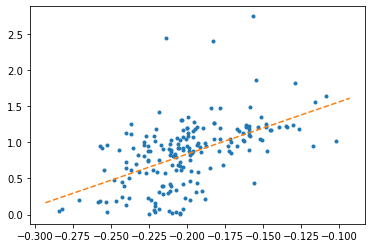

In [99]:
#graph data
def abline(slope, intercept):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

x_vals = []
y_vals = []
for seq in valcarcel_data:
    y_vals.append(valcarcel_data[seq][0]) #x is valcarcel's observations
    x_vals.append(valcarcel_data[seq][1]) #y is our predictment
slope, intercept, r_value, p_value, std_err = stats.linregress(x_vals,y_vals)
plt.plot(x_vals,y_vals,'.')
abline(slope,intercept)
print("r^2 = " + str(r_value**2))
print("y = " + str(slope) + "x + " + str(intercept))

## This section is for predicting the data we built our model on